
#The Mathematical Building Blocks of Deep Learning (Part II)

In this notebook we are going to see: 

An example of a neural network The tensor concept and operations with tensors How neural networks learn through the backpropagation algorithm and gradient descent 

EXERCISES: During this practice notebook you will see exercises and questions marked with ❓ ❓❓. 

You can answer by adding new blocks of (brief) text and/or code after the question.

#Dense Class
The Dense class implements the following transformation of the input data where W and b are the model data:

`output = activation(dot(W, input) + b)`


Where the activity function is usually relu for hidden layers or softmax in the last layer.

Object Orientation Note in Python:

The `__init__` method is the class's constructor and is called when creating an instance of the class to assign default values ​​to the class's attributes.
The `__call__` method is the method that is called when the class instance is called as if it were a function.

In [ ]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

❓❓❓ Try changing the way the weights are initialized and see the effect. ❓❓❓

✅

In [ ]:
import tensorflow as tf

class NaiveDenseN:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        # Change the way weights are initialized
        stddev = 1.0 / tf.math.sqrt(float(input_size))
        w_shape = (input_size, output_size)
        w_initial_value = tf.random.normal(w_shape, mean=0.0, stddev=stddev)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

In this example, we change the way the weights are initialized by using the standard deviation of a Gaussian distribution with mean 0 and standard deviation 1/sqrt(input_size) to initialize the weights. This is a common initialization scheme known as "Xavier initialization", which has been shown to work well in practice for many neural networks.

Sequential Class


This class will be in charge of chaining the layers. It's going to package up a list of layers and expose a `__call__()` method that simply calls the underlying layers in order.

In [ ]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

Using the NaiveDense and NaiveSequential classes we can create something similar to a Keras model:

In [ ]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

❓❓❓ EXERCISE: Try changing the hidden layer activation function from those available in tf.nn❓❓❓

✅

In [ ]:
new_model = NaiveSequential([
    NaiveDenseN(input_size=28 * 28, output_size=512, activation=tf.nn.sigmoid),
    NaiveDenseN(input_size=512, output_size=10, activation=tf.nn.softmax)
])

Batches


This class will allow us to iterate over the training images in mini-batches.

In [3]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

#Running a Training Step 

The most difficult part of the process is the "training step": updating the model weights after processing a batch of data. We need to: 

1. Calculate the model predictions for the batch images. 
2. Calculate the loss value for these predictions, given the actual labels. 
3. Calculate the gradient of the loss with respect to the model weights. 
4. Move the weights a small amount in the opposite direction of the gradient. 

We are going to calculate the gradient with TensorFlow's GradientTape.

In [ ]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        # (1) 
        predictions = model(images_batch) 
        # (2)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        # (2)
        average_loss = tf.reduce_mean(per_sample_losses)
    # (3) 
    gradients = tape.gradient(average_loss, model.weights)
    # (4) 
    update_weights(gradients, model.weights)
    return average_loss

The `update_weights` function will move the weights "a bit" in the direction that reduces loss for this batch. The magnitude of this movement will depend on the `learning_rate` and will be in the opposite direction to the gradient, therefore it is enough to subtract the gradient multiplied by `learning_rate` from the weights to update them.



```
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate)
```



In practice it will be very rare that we implement the updating of the weights by hand and we will use one of the Keras optimizers:

In [ ]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

✅

In [ ]:
from tensorflow.keras import optimizers

# Replace the SGD optimizer with Adam
optimizer = optimizers.Adam(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

In this example, we replace the SGD optimizer with the Adam optimizer by creating an Adam optimizer object and passing it to the apply_gradients method of the NaiveDense layer.

#The complete learning loop
A learning epoch consists of repeating a learning step for each batch of the training set. The entire learning loop is simply the repetition of an epoch.

In [ ]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

Let's test our model:

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 0
loss at batch 0: 4.20
loss at batch 100: 2.24
loss at batch 200: 2.18
loss at batch 300: 2.06
loss at batch 400: 2.27
Epoch 1
loss at batch 0: 1.90
loss at batch 100: 1.87
loss at batch 200: 1.81
loss at batch 300: 1.70
loss at batch 400: 1.88
Epoch 2
loss at batch 0: 1.57
loss at batch 100: 1.57
loss at batch 200: 1.48
loss at batch 300: 1.39
loss at batch 400: 1.54
Epoch 3
loss at batch 0: 1.31
loss at batch 100: 1.33
loss at batch 200: 1.22
loss at batch 300: 1.18
loss at batch 400: 1.29
Epoch 4
loss at batch 0: 1.12
loss at batch 100: 1.14
loss at batch 200: 1.02
loss at batch 300: 1.02
loss at batch 400: 1.12
Epoch 5
loss at batch 0: 0.97
loss at batch 100: 1.01
loss at batch 200: 0.89
loss at batch 300: 0.90
loss at batch 400: 0.99
Epoch 6
loss at batch 0: 0.87
loss at batch 100: 0.90
loss at batch 200: 0.79
loss at batch 300: 0.82
loss at batch 400: 0.90
Epoch 7
loss at batch 0: 0.79
loss at batch 100: 0.82

❓❓❓

EXERCISE: Modify the previous code to save the history of the loss function and draw it on a graph in order to study the convergence of the algorithm. Analyze the output of the evolution of the error function. Has it always been descending? What could we do to improve accuracy?

Try replacing the optimizer with another from Keras.

Try changing the learning rate and triggering the moment.

❓❓❓

✅

In [ ]:
import matplotlib.pyplot as plt

def fit(model, images, labels, epochs, batch_size=128):
    history = {"loss": []}
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")
            history["loss"].append(loss)
        plt.plot(history["loss"])
        plt.title("Training Loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
    return history

#Model evaluation
We can evaluate the model by choosing the output neuron with the highest value in the prediction of the test set and comparing it with the expected label.

❓❓❓ EXERCISE: Complete the code to choose the neuron with the highest probability ❓❓❓

In [ ]:
import numpy as np
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = 1 # CHANGE HERE
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

accuracy: 0.11


In [ ]:
predictions[0].argmax()

7

✅

In [ ]:
import numpy as np
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

❓❓❓

EXERCISE:

Put all the code we have developed in a single cell so that it allows for multiple executions.

1. Definition of classes (layer and model) and auxiliary functions (batch)
2. Optimizer and update weights
3. Training step and fit() function
4. Load data
5. Define model
6. Fit the model by calling fit()
7. Evaluate the model
❓❓❓

✅

Epoch 0
loss at batch 0: 2.31
loss at batch 100: 0.43
loss at batch 200: 0.30
loss at batch 300: 0.27
loss at batch 400: 0.36


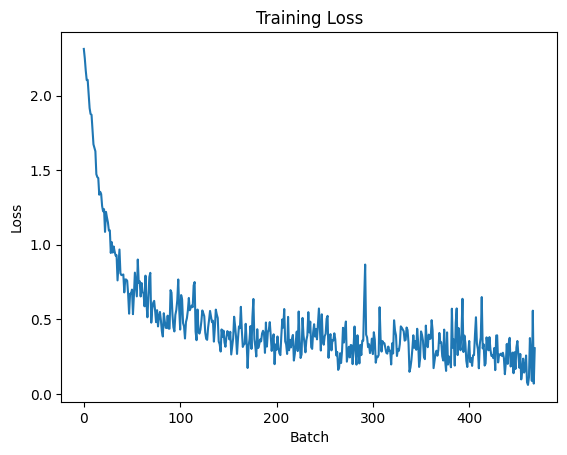

Epoch 1
loss at batch 0: 0.20
loss at batch 100: 0.19
loss at batch 200: 0.22
loss at batch 300: 0.19
loss at batch 400: 0.26


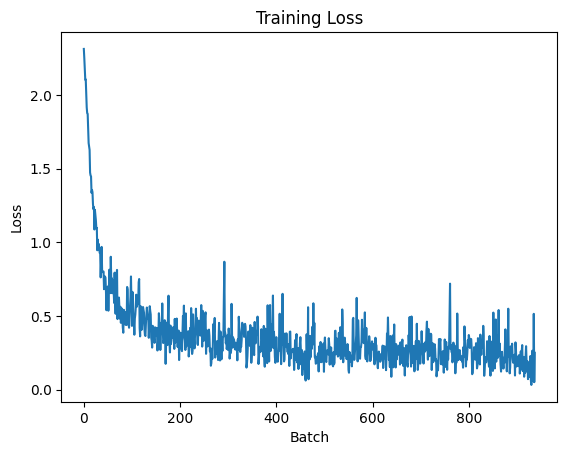

Epoch 2
loss at batch 0: 0.14
loss at batch 100: 0.13
loss at batch 200: 0.19
loss at batch 300: 0.16
loss at batch 400: 0.19


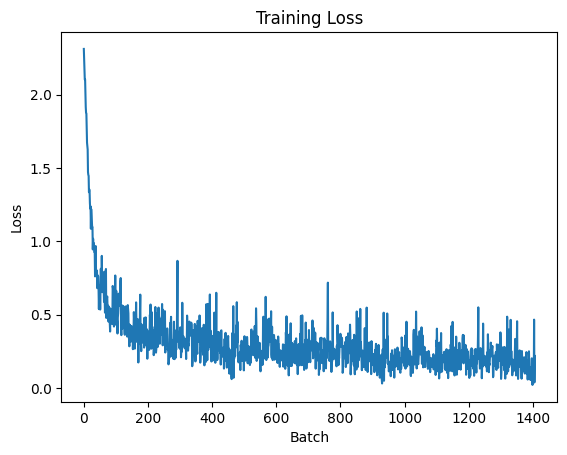

accuracy: 0.95


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist

# Define the NaiveDense layer class
class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        # Initialize weights randomly
        stddev = 1.0 / tf.math.sqrt(float(input_size))
        w_shape = (input_size, output_size)
        w_initial_value = tf.random.normal(w_shape, mean=0.0, stddev=stddev)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

# Define the NaiveSequential model class
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights += layer.weights
        return weights

# Define the BatchGenerator function
class BatchGenerator:
    def __init__(self, images, labels, batch_size=128, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0

    def __len__(self):
        return int(np.ceil(len(self.images) / float(self.batch_size)))

    def __iter__(self):
        return self

    def __next__(self):
        if self.start_index >= len(self.images):
            raise StopIteration
        end_index = self.start_index + self.batch_size
        images_batch = self.images[self.start_index:end_index]
        labels_batch = self.labels[self.start_index:end_index]
        self.start_index += self.batch_size
        if self.shuffle:
            idx = np.random.permutation(len(images_batch))
            images_batch = images_batch[idx]
            labels_batch = labels_batch[idx]
        return images_batch, labels_batch

# Define the update_weights function
optimizer = optimizers.Adam(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

# Define the one_training_step function
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

# Define the fit function
def fit(model, images, labels, epochs, batch_size=128):
    history = {"loss": []}
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels, batch_size=batch_size)
        for batch_counter in range(batch_generator.__len__()):
            images_batch, labels_batch = batch_generator.__next__()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")
            history["loss"].append(loss)
        plt.plot(history["loss"])
        plt.title("Training Loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
    return history

from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.sigmoid),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])

fit(model, train_images, train_labels, epochs=3, batch_size=128)

predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")